<a href="https://colab.research.google.com/github/Kovylyaev/Music_MMLS/blob/main/MUSIC_MMLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music MMLS

# Библотеки

In [1]:
!pip install librosa
!pip install pydub

In [2]:
%matplotlib inline
import librosa
import librosa.display
import IPython
import IPython.display as ipd
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import shutil
import kagglehub
import os
import torch
import torch.utils.data
from pydub import AudioSegment
import math

# Данные

## Скачивание данных

In [3]:
def download_data(dataset_path, out_path, dataset_path_add = None, audio_duration = None):
    path = kagglehub.dataset_download(dataset_path)
    path = shutil.move(path, '/content/sample_data/temp_Data')

    if dataset_path_add is not None:
        path = os.path.join(path, dataset_path_add)

    for folder in os.listdir(path):
        for file_name in os.listdir(path + '/' + folder):
            full_path = os.path.join(path, folder, file_name)

            if audio_duration is not None:
                sound = AudioSegment.from_file(full_path)
                num_segments = math.ceil(len(sound) / (audio_duration * 1000))

                for i in range(num_segments):
                    start_time = i * audio_duration * 1000
                    end_time = min((i + 1) * audio_duration * 1000, len(sound))
                    segment = sound[start_time:end_time]

                    segment.export(f"{out_path}/{file_name}_part_{i+1}.wav", format="wav")
            else:
                shutil.move(full_path, os.path.join(out_path, file_name))


In [4]:
!mkdir /content/sample_data/Data
!mkdir /content/sample_data/Data/all_records
!mkdir /content/sample_data/Data/noise

In [5]:
download_data(dataset_path="andradaolteanu/gtzan-dataset-music-genre-classification", out_path='/content/sample_data/Data/all_records', dataset_path_add='Data/genres_original')
download_data(dataset_path="mlneo07/random-noise-audio", out_path='/content/sample_data/Data/noise', audio_duration=30)

100%|██████████| 1.21G/1.21G [00:42<00:00, 30.7MB/s]

Extracting files...


100%|██████████| 6.53G/6.53G [04:06<00:00, 28.5MB/s]

Extracting files...


In [6]:
# if os.path.exists('/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1'):
#     shutil.rmtree('/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1')
# if os.path.exists('/content/sample_data/Data'):
#     shutil.rmtree('/content/sample_data/Data')

# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
# path = shutil.move(path + '/Data', '/content/sample_data')

In [7]:
# genres_folder = os.path.join(path, 'genres_original')
# all_records_path = os.path.join(path + '/all_records')

# for folder in os.listdir(genres_folder):
#   for file_name in os.listdir(genres_folder + '/' + folder):

#     if file_name.count('.') > 1:
#         num_dots = file_name.count('.')
#         norm_file_name = file_name.replace('.', '_', num_dots - 1)
#     else:
#         norm_file_name = file_name

#     full_path = os.path.join(genres_folder, folder, file_name)
#     full_norm_path = os.path.join(genres_folder, folder, norm_file_name)

#     os.rename(full_path, full_norm_path)
#     shutil.move(full_norm_path, os.path.join(all_records_path, norm_file_name))

# print(os.listdir(path + '/all_records'))

In [8]:
# if os.path.exists('/root/.cache/kagglehub/datasets/mlneo07/random-noise-audio/versions/2'):
#     shutil.rmtree('/root/.cache/kagglehub/datasets/mlneo07/random-noise-audio/versions/2')
# if os.path.exists('/content/sample_data/Data/2'):
#     shutil.rmtree('/content/sample_data/Data/2')

# path = kagglehub.dataset_download("mlneo07/random-noise-audio")
# path = shutil.move(path, '/content/sample_data/Data')

In [9]:
# new_path = '/content/sample_data/Data/noise'

# for folder in os.listdir(path):
#   for file_name in os.listdir(path + '/' + folder):

#     full_path = os.path.join(path, folder, file_name)
#     sound = AudioSegment.from_file(full_path)
#     num_segments = math.ceil(len(sound) / (30 * 1000))

#     for i in range(num_segments):
#         start_time = i * 30 * 1000
#         end_time = min((i + 1) * 30 * 1000, len(sound))
#         segment = sound[start_time:end_time]

#         segment.export(f"{new_path}/{file_name}_part_{i+1}.wav", format="wav")

# print(os.listdir(new_path))

## Посмотреть данные

### Загрузка

In [35]:
import torchaudio
from torchaudio.functional import resample

audio_file = '/content/sample_data/Data/all_records/blues.00000.wav'
audio, sample_rate_a = torchaudio.load(audio_file, normalize=True)

noise_file = '/content/sample_data/Data/noise/brown_noise_32000_0.wav_part_1.wav'
noise, sample_rate_n = torchaudio.load(noise_file, normalize=True)

audio = resample(audio, orig_freq=sample_rate_a, new_freq=32000)
noise = resample(noise, orig_freq=sample_rate_n, new_freq=32000)

min_size = min(audio.shape[1], noise.shape[1])
audio = audio.flatten()[:min_size]
noise = noise.flatten()[:min_size]
print(f"Sequence lenght - {min_size}")

audio_with_noise = audio + noise / 5

Sequence lenght - 960000


### Визуализация

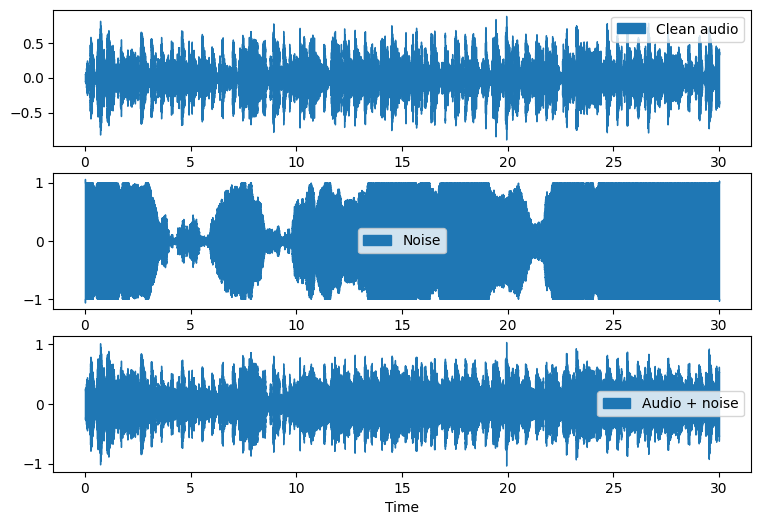

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6))

librosa.display.waveshow(audio, sr=sample_rate, ax=axs[0], label='Clean audio')
axs[0].legend()

librosa.display.waveshow(noise, sr=sample_rate, ax=axs[1], label='Noise')
axs[1].legend()

librosa.display.waveshow(audio_with_noise, sr=sample_rate, ax=axs[2], label='Audio + noise')
axs[2].legend()

### Послушать

In [13]:
# Clean audio
ipd.Audio(audio_file)

In [14]:
# Noise
ipd.Audio(noise_file)

### Мел-спектрограммы

In [44]:
from torchaudio.transforms import Spectrogram, MelSpectrogram, AmplitudeToDB

spectrogram = MelSpectrogram(sample_rate)
to_db = AmplitudeToDB(stype="magnitude")

clean_mel_spectrogram = spectrogram(audio)
clean_db_mel_spec = to_db(clean_mel_spectrogram)

noise_mel_spectrogram = spectrogram(noise)
noise_db_mel_spec = to_db(noise_mel_spectrogram)

with_noise_mel_spectrogram = spectrogram(audio_with_noise)
with_noise_db_mel_spec = to_db(with_noise_mel_spectrogram)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.3733e-04, -2.4948e-03,  5.3406e-05,  ...,  7.0953e-04,
         -1.0452e-03,  5.4932e-04],
        [ 0.0000e+00, -2.9221e-03,  7.0953e-04,  ..., -3.0518e-05,
          4.7302e-03, -1.3504e-03],
        [ 4.1199e-04, -2.4414e-04, -5.9357e-03,  ..., -9.8419e-04,
          6.6681e-03, -5.6458e-04]])


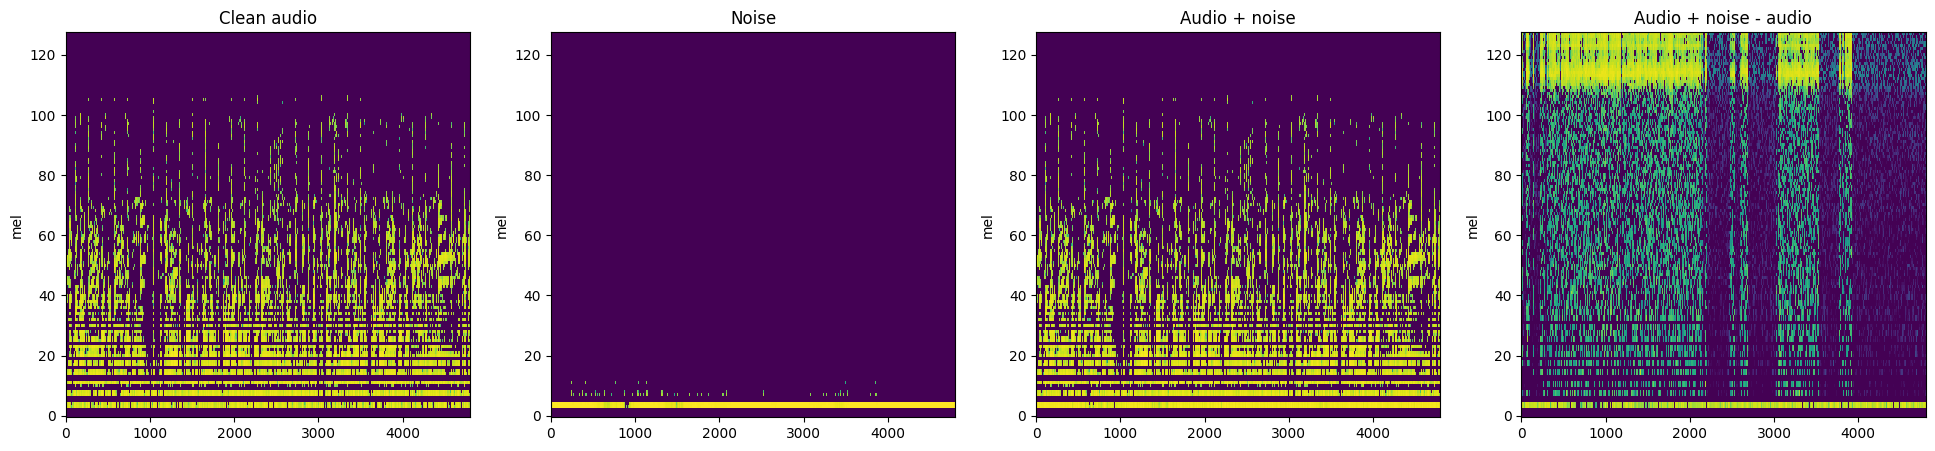

In [45]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
fig, axs = plt.subplots(1, 4, figsize=(24, 5))abd

plot_spectrogram(clean_db_mel_spec, title='Clean audio', ylabel="mel", ax=axs[0])

plot_spectrogram(noise_db_mel_spec, title='Noise', ylabel="mel", ax=axs[1])

plot_spectrogram(with_noise_db_mel_spec, title='Audio + noise', ylabel="mel", ax=axs[2])

plot_spectrogram(with_noise_db_mel_spec - clean_db_mel_spec, title='Audio + noise - audio',  ylabel="mel", ax=axs[3])
print(with_noise_db_mel_spec - clean_db_mel_spec)


### Тест

In [ ]:
print(clean_spec.shape)

(90, 1292)


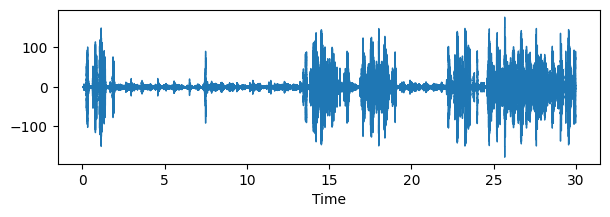

In [ ]:
# print(clean_log_mel_spectrogram)
# print(with_noise_log_mel_spectrogram - clean_log_mel_spectrogram)
clean_log_spec = with_noise_log_mel_spectrogram - noise_log_mel_spectrogram

clean_spec = librosa.db_to_power(clean_log_spec)
clean_audio = librosa.feature.inverse.mel_to_audio(M=clean_spec, sr=sample_rate, n_fft=2048, hop_length=512)


plt.figure(figsize=(7, 2))
librosa.display.waveshow(clean_audio, sr=sample_rate)

# plt.figure(figsize = (25, 10))
# librosa.display.specshow(diff_log_spec, x_axis = "time", y_axis = "mel", sr = sample_rate)
# plt.colorbar(format = "%+2.f")
# plt.show()

## Датасет

Возможно, в будущем заменим librosa на torchaudio, т.к. он лучше оптимизирован для больших данных и работы на GPU

In [ ]:
class Musci_Dataset(torch.utils.data.Dataset):
    def __init__(self, clean_files_dir: str, noise_files_dir: str):
        """Initializes Dataset with passed files.
        Args:
            clean_files: path to files of clean music,
            noise_files: path to files of noise.
        """
        self.clean_music = os.listdir(clean_files_dir)
        self.clean_num = len(self.clean_music)

        self.noise = os.listdir(noise_files_dir)
        self.noise_num = len(self.noise)


    def __getitem__(self, idx: int):
        """Returns the object by given index.
        Args:
            idx - index of the record.
        Returns:
            record with noise and clean one.
        """

        clean_ind = idx // self.noise_num
        clean_record, sample_rate = librosa.load(self.clean_music[clean_ind])

        noise_ind = idx % self.noise_num
        noise_record, _ = librosa.load(self.noise[noise_ind])

        record_with_noise = clean_record + noise_record

        melspec_with_noise = librosa.feature.melspectrogram(y=record_with_noise, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=90)
        melspec_clean = librosa.feature.melspectrogram(y=clean_record, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=90)

        log_melspec_with_noise = librosa.power_to_db(melspec_with_noise)
        log_melspec_clean = librosa.power_to_db(melspec_clean)

        return log_melspec_with_noise, log_melspec_clean


    def __len__(self):
        """Returns num of different combinations of clean_rec + noise, containing in dataset."""

        return self.clean_num * self.noise_num